In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from PIL import Image
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from fractions import Fraction
font = {'family' : 'Times New Roman',
    'weight' : 'light',
    'size'   : 13,
    }
plt.rc('font',family='Times New Roman')

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Times New Roman'  # 用于正常数学文本
matplotlib.rcParams['mathtext.it'] = 'Times New Roman:italic'  # 用于斜体数学文本

#def curve_color():
def set_axis(axes,xmaj=0.5,xmin=0.125,ymaj=0.5,ymin=0.125,aspect=None):
    if aspect:
        axes.set_aspect(aspect)
    axes.minorticks_on()
    axes.tick_params(axis="both", which="major", direction="in", width=1, length=4, labelsize=10)
    axes.tick_params(axis="both", which="minor", direction="in", width=1, length=2, labelsize=10)

    axes.xaxis.set_major_locator(MultipleLocator(xmaj))
    axes.xaxis.set_minor_locator(MultipleLocator(xmin))
    axes.yaxis.set_major_locator(MultipleLocator(ymaj))
    axes.yaxis.set_minor_locator(MultipleLocator(ymin))                    
    axes.set_xlabel(r'$x$',fontdict={'size': 12})
    axes.set_ylabel(r'$T$',fontdict={'size': 12})
    #axes.set_xticks(fontsize=10)
    #axes.set_yticks(fontsize=10)
    


In [2]:
class solver:
    def __init__(self,nx=100,sigma=0.1,gamma=1,init=None,bcs=None):
        """"
        nx: the number of cells, or the total number of nodes is nx+1
        nt: the number of iterations
        sigma: stable criterion, i.e. gamma dt/dx^2
        gamma: thermal diffusivity
        u_curr: u^n; u_next: u^{n+1}
        """
        self.nx=nx
        self.sigma=sigma
        self.gamma=gamma
        if init==None:
            init=lambda x: 0 if 0<x<0.3 else (1 if 0.3<=x<=0.6 else 1+2.5*(x-0.6))
        if bcs==None:
            bcs={'a':lambda t: 0, 'b': lambda t: 2}
        self.init=init
        self.bcs=bcs
        
        self.dx=1./nx
        self.dt=sigma*self.dx**2/gamma
        self.x_range=np.arange(0,1+self.dx,self.dx)
        self.t_range=np.arange(0,1+self.dt,self.dt)

        self.u_curr=np.zeros((nx+1,))
        self.u_next=np.zeros((nx+1,))
        for i in range(nx+1):
            self.u_curr[i]=self.init(i*self.dx)
        self.u_curr[0]=self.bcs['a'](0)
        self.u_curr[-1]=self.bcs['b'](0)
        #plt.plot(self.x_range,self.u_curr,color='b')
    
    def method(self, u_curr, u_next, tt):
        """"
        Calculate u_next with u_curr, update and return u_curr and u_next
        """
        pass
    
    def saves(self,arg):
        return
        #arg.append(self.u_curr)

    def solve(self, nt, arg_plot=None, arg_save=None):
        print('Solving the equation, nt: {}'.format(nt))
        if arg_plot and arg_plot['all']:
            arg_plot['all']['cmap'] = plt.get_cmap('Spectral')
            arg_plot['all']['norm'] = plt.Normalize(vmin=self.t_range.min(), vmax=self.t_range.max())
            arg_plot['fig']=plt.figure(dpi=120)
            arg_plot['axes']=plt.gca()
            set_axis(arg_plot['axes'],ymaj=arg_plot['ticks'][0],ymin=arg_plot['ticks'][1])
            
        for tt in range(nt+1):
            if arg_plot and tt%arg_plot['freq']==0:
                if arg_plot['single']:
                    print('t: {}'.format(tt))
                    arg_plot['fig']=plt.figure(dpi=120)
                    arg_plot['axes']=plt.gca()
                    set_axis(arg_plot['axes'],ymaj=arg_plot['ticks'][0],ymin=arg_plot['ticks'][1])
                    plt.plot(self.x_range,self.u_curr,color=arg_plot['single']['color'])
                    plt.show()
                if arg_plot['all']:
                    color = arg_plot['all']['cmap'](arg_plot['all']['norm'](tt*self.dt))
                    plt.plot(self.x_range,self.u_curr,color=color)

            if arg_save and tt%arg_save['freq']==0:
                #self.saves(arg_save['list'])
                arg_save['list'].append((tt,self.u_curr.copy()))
            #self.u_curr, self.u_next=self.method(self.u_curr, self.u_next)
            #print(222)
            self.u_curr, self.u_next=self.method(self.u_curr.copy(), self.u_next.copy(), tt)
        if arg_plot and arg_plot['all']:
            sm = plt.cm.ScalarMappable(norm=arg_plot['all']['norm'], cmap=arg_plot['all']['cmap'])
            cbar = plt.colorbar(sm, ax=arg_plot['axes'], label='Time')
            cbar.set_ticks(np.linspace(self.t_range.min(), self.t_range.max(), 5))  # 设置刻度
            plt.show()
 

In [3]:
plot_all={'cmap':None,'norm':None}
plot_single={'color':'b'}
set_single=lambda freq, ticks=[0.5,0.125]: {'all':None,'single':plot_single, 'fig':None, 'axes':None, 'ticks':ticks, 'freq':freq}
set_all=lambda freq, ticks=[0.5,0.125]: {'all':plot_all,'single':None, 'fig':None, 'axes':None, 'ticks':ticks, 'freq':freq}
set_save=lambda _list, freq=1: {'list': _list, 'freq':freq}

In [4]:
class FTCS(solver):
    def __init__(self,nx=100,sigma=0.1,gamma=1,init=None,bcs=None):
        solver.__init__(self,nx,sigma,gamma,init,bcs)
        self._list=[]
        print('Method: FTCS, nx: {}, dx: {}, sigma: {}, dt: {}'.format(self.nx, self.dx, self.sigma, self.dt))
    
    def method(self, u_curr, u_next, tt):
        u_next=self.sigma*np.roll(u_curr,shift=-1)+(1-2*self.sigma)*u_curr+self.sigma*np.roll(u_curr,shift=1)
        u_next[0]=self.bcs['a'](tt*self.dt)
        u_next[-1]=self.bcs['b'](tt*self.dt)
        u_curr=u_next
        np.nan_to_num(u_curr, nan=9999, copy=False)
        u_curr[u_curr>9999]=9999
        np.nan_to_num(u_next, nan=9999, copy=False)
        u_next[u_next>9999]=9999
        return u_curr, u_next
    
    def solve(self, nt):
        return solver.solve(self,nt,arg_plot=None,arg_save=set_save(self._list))
    
    def plot_result1(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.plot([0,1],[0,2],label='Stable solution')
        plt.ylim(-0.2, 2.2)
        plt.legend()#loc='upper left'
        plt.show()

    def plot_result2(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.ylim(-0.2, 3.2)
        plt.legend()#loc='upper left'
        plt.show()

In [5]:
class BTCS(solver):
    def __init__(self,nx=100,sigma=0.1,gamma=1,init=None,bcs=None):
        solver.__init__(self,nx,sigma,gamma,init,bcs)
        self._list=[]
        print('Method: BTCS, nx: {}, dx: {}, sigma: {}, dt: {}'.format(self.nx, self.dx, self.sigma, self.dt))
    
    #Thomas Algorithm
    def TDMA(self,l,d,u,b):
        """"
        Thomas Algorithm for solving triagonal matrix, i.e. Ax=b, where A is a triagonal matrix.
        l is the lower diagon d is diagon, u is upper diagon, b
        """
        for i in range(len(l)):
            l[i]/=d[i]
            d[i+1]-=l[i]*u[i]
            b[i+1]-=l[i]*b[i]
        b[-1]/=d[-1]
        for i in range(len(l)):
            j=len(l)-i-1
            b[j]=(b[j]-u[j]*b[j+1])/d[j]
        return b

    def method(self, u_curr, u_next, tt):
        l=-self.sigma*np.ones(self.nx)
        l[-1]=0.
        u=-self.sigma*np.ones(self.nx)
        u[0]=0.
        d=(1+2.*self.sigma)*np.ones(self.nx+1)
        d[0]=1.
        d[-1]=1.
        u_curr[0]=self.bcs['a'](tt*self.dt)
        u_curr[-1]=self.bcs['b'](tt*self.dt)
        u_curr=self.TDMA(l,d,u,u_curr)
        u_curr[0]=self.bcs['a'](tt*self.dt)
        u_curr[-1]=self.bcs['b'](tt*self.dt)
        return u_curr, u_next
    
    def solve(self, nt):
        return solver.solve(self,nt,arg_plot=None,arg_save=set_save(self._list))
    
    def plot_result1(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.plot([0,1],[0,2],label='Stable solution')
        plt.ylim(-0.2, 2.2)
        plt.legend()#loc='upper left'
        plt.show()

    def plot_result2(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.ylim(-0.2, 2.2)
        plt.legend()#loc='upper left'
        plt.show()

In [6]:
class CTCS(solver):
    def __init__(self,nx=100,sigma=0.1,gamma=1,init=None,bcs=None):
        solver.__init__(self,nx,sigma,gamma,init,bcs)
        self.u_temp=np.zeros((nx+1,))
        self._list=[]
        #Calculate u_next with FTCS
        self.u_next=self.sigma*np.roll(self.u_curr,shift=-1)+(1-2*self.sigma)*self.u_curr+self.sigma*np.roll(self.u_curr,shift=1)
        self.u_next[0]=self.bcs['a'](1*self.dt)
        self.u_next[-1]=self.bcs['b'](1*self.dt)
        print('Method: CTCS, nx: {}, dx: {}, sigma: {}, dt: {}'.format(self.nx, self.dx, self.sigma, self.dt))
    
    def method(self, u_curr, u_next, tt):
        u_temp=u_curr+self.sigma*(np.roll(u_next,shift=1)-2*u_next+np.roll(u_next,shift=-1))
        u_next[0]=self.bcs['a'](tt*self.dt)
        u_next[-1]=self.bcs['b'](tt*self.dt)
        u_curr=u_next
        u_next=u_temp
        np.nan_to_num(u_curr, nan=9999, copy=False)
        u_curr[u_curr>9999]=9999
        np.nan_to_num(u_next, nan=9999, copy=False)
        u_next[u_next>9999]=9999
        return u_curr, u_next
    
    def solve(self, nt):
        return solver.solve(self,nt,arg_plot=None,arg_save=set_save(self._list))
    
    def plot_result1(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.plot([0,1],[0,2],label='Stable solution')
        plt.ylim(-0.2, 2.2)
        plt.legend()#loc='upper left'
        plt.show()

    def plot_result2(self, _range):
        print(len(self._list))
        plt.figure(dpi=120)
        set_axis(plt.gca(),ymaj=1,ymin=0.25)
        for i in _range:
            plt.plot(self.x_range,self._list[i][1],label=r'$t=$'+'{:.4f}'.format(self._list[i][0]*self.dt)+r', $i=$'+'{:d}'.format(self._list[i][0]))
            #plt.text(0.25,1.75,'t={:.5f}'.format(FTCS_list1[i][0]*testFTCS_1.dt))
        plt.ylim(-0.2, 2.2)
        plt.legend()#loc='upper left'
        plt.show()

Method: FTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 1e-05
Solving the equation, nt: 99999
100000


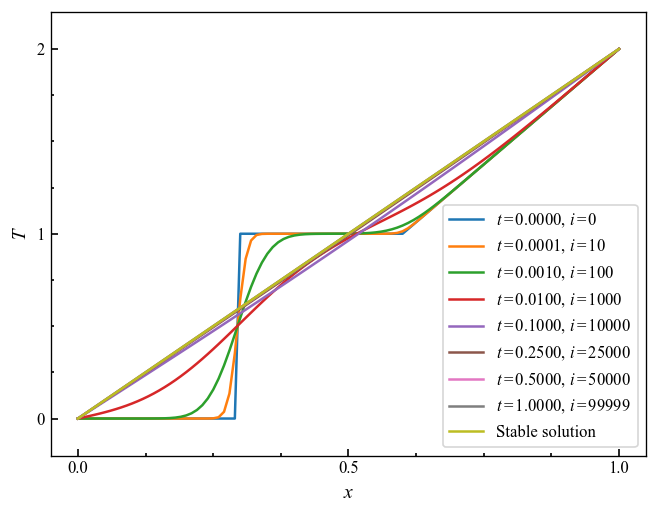

Method: FTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 5e-05
Solving the equation, nt: 20000
20001


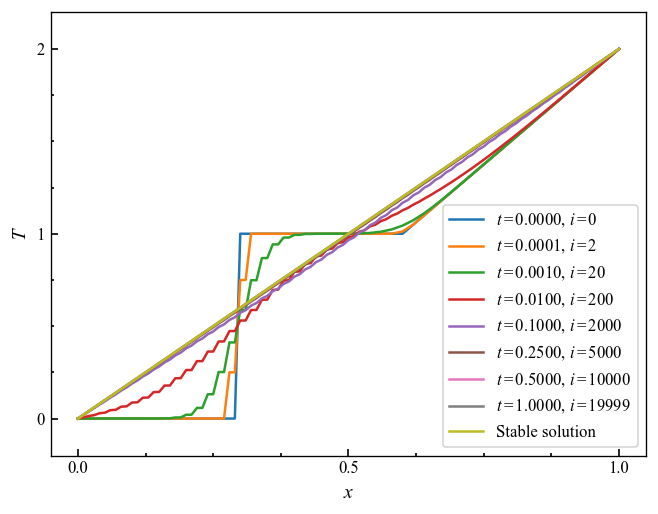

Method: FTCS, nx: 100, dx: 0.01, sigma: 1, dt: 0.0001
Solving the equation, nt: 10000


C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2923798320.py:8: RuntimeWarning: overflow encountered in add
  u_next=self.sigma*np.roll(u_curr,shift=-1)+(1-2*self.sigma)*u_curr+self.sigma*np.roll(u_curr,shift=1)


10001


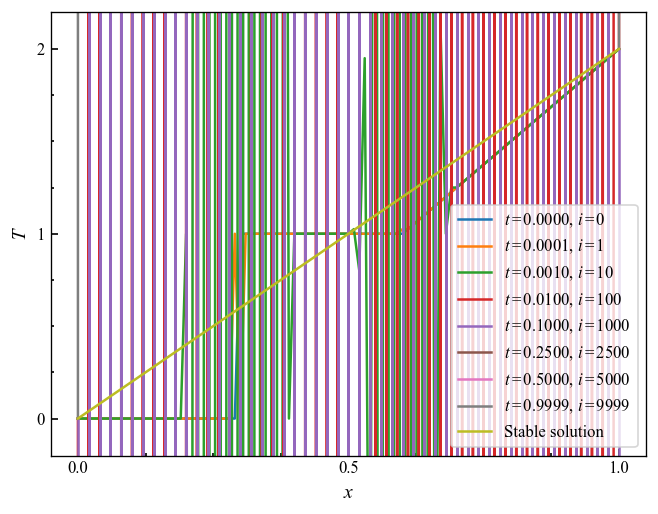

10001


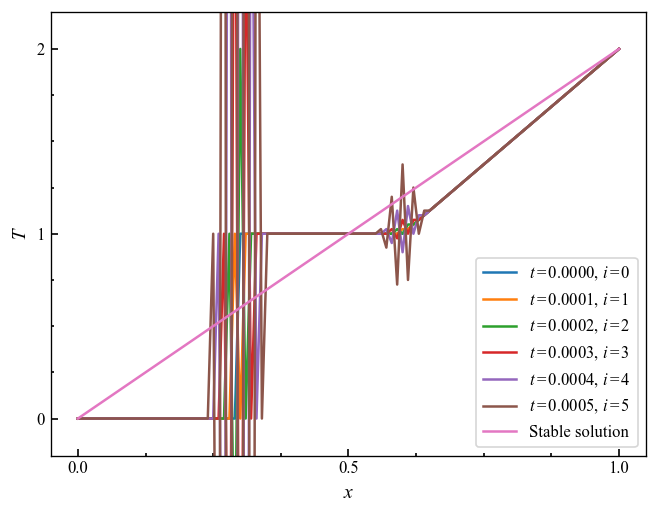

In [10]:
testFTCS_1=FTCS(100, 0.1)
#testFTCS_1.solve(int(1/testFTCS_1.dt), set_all(int(1/testFTCS_1.dt/100)))
#testFTCS_1.solve(int(1/testFTCS_1.dt), set_single(int(1/testFTCS_1.dt/100)))
#FTCS_list1=[]
#testFTCS_1.solve(int(1/testFTCS_1.dt), arg_save=set_save(FTCS_list1))
testFTCS_1.solve(int(1/testFTCS_1.dt))
testFTCS_1.plot_result1([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testFTCS_2=FTCS(100, 0.5)
#testFTCS_2.solve(int(1/testFTCS_2.dt), set_single(int(1/testFTCS_2.dt/100)))
testFTCS_2.solve(int(1/testFTCS_2.dt))
testFTCS_2.plot_result1([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])


testFTCS_3=FTCS(100, 1)
#testFTCS_3.solve(int(1/testFTCS_3.dt), set_single(int(1/testFTCS_3.dt/100)))
testFTCS_3.solve(int(1/testFTCS_3.dt))
testFTCS_3.plot_result1([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testFTCS_3.plot_result1([0, 1, 2, 3, 4, 5])

Method: FTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 1e-05
Solving the equation, nt: 99999
100000


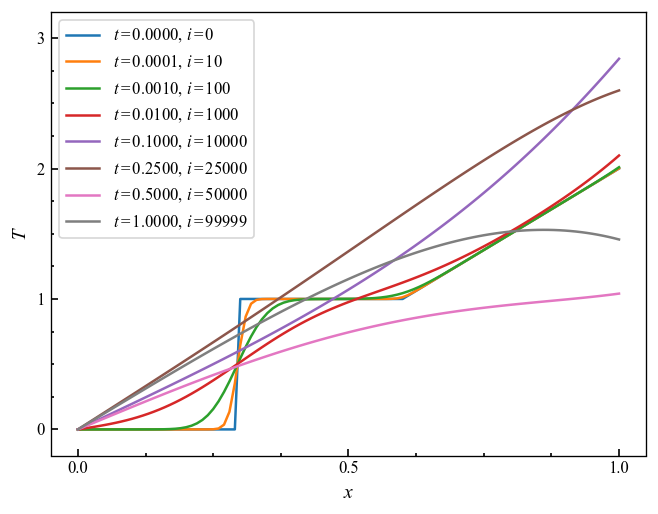

Method: FTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 5e-05
Solving the equation, nt: 20000
20001


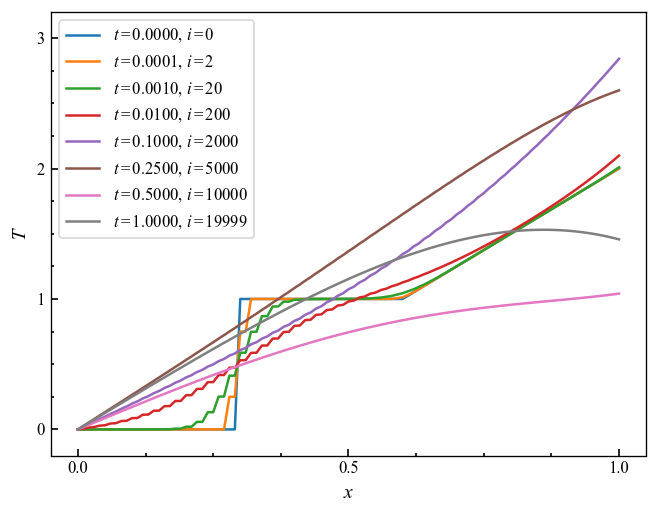

Method: FTCS, nx: 100, dx: 0.01, sigma: 1, dt: 0.0001
Solving the equation, nt: 10000


C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2923798320.py:8: RuntimeWarning: overflow encountered in add
  u_next=self.sigma*np.roll(u_curr,shift=-1)+(1-2*self.sigma)*u_curr+self.sigma*np.roll(u_curr,shift=1)


10001


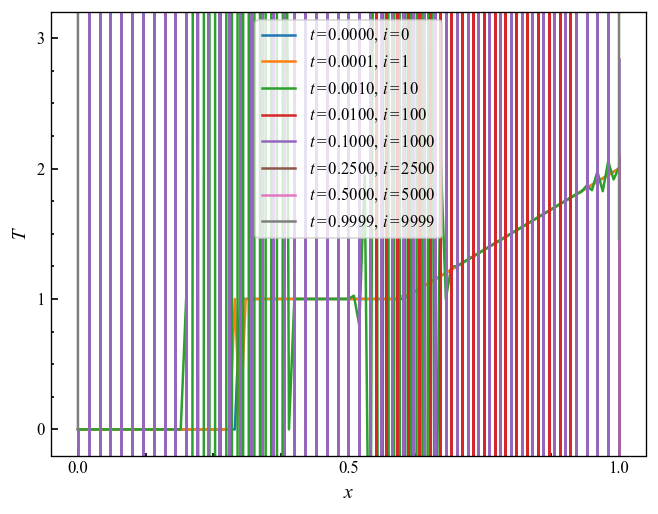

10001


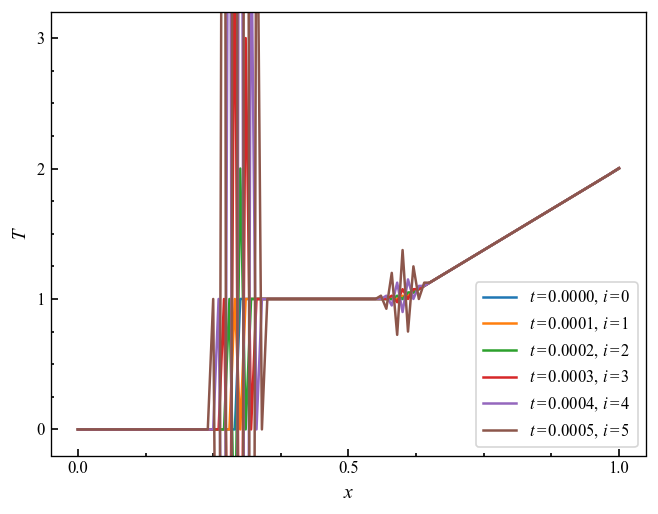

In [11]:
from math import sin
bcsin={'a': (lambda t: 0), 'b': (lambda t: 2+sin(10*t))}
testFTCS_4=FTCS(100,0.1,bcs=bcsin)
#testFTCS_4.solve(int(1/testFTCS_4.dt), set_all(int(1/testFTCS_4.dt/100)))
testFTCS_4.solve(int(1/testFTCS_4.dt))
testFTCS_4.plot_result2([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testFTCS_5=FTCS(100,0.5,bcs=bcsin)
#testFTCS_5.solve(int(1/testFTCS_5.dt), set_all(int(1/testFTCS_5.dt/100)))
testFTCS_5.solve(int(1/testFTCS_5.dt))
testFTCS_5.plot_result2([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])

testFTCS_6=FTCS(100,1,bcs=bcsin)
#testFTCS_6.solve(int(1/testFTCS_6.dt), set_all(int(1/testFTCS_6.dt/100)))
testFTCS_6.solve(int(1/testFTCS_6.dt))
testFTCS_6.plot_result2([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testFTCS_6.plot_result2([0, 1, 2, 3, 4, 5])

Method: BTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 2.0000000000000003e-06
Solving the equation, nt: 499999
500000


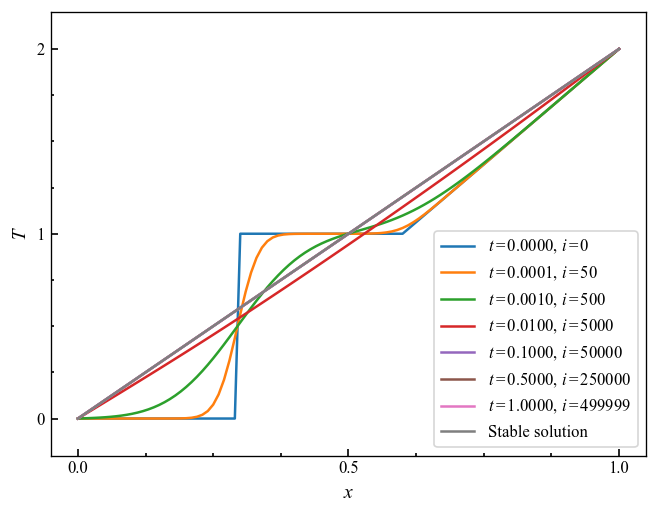

Method: BTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 1e-05
Solving the equation, nt: 99999
100000


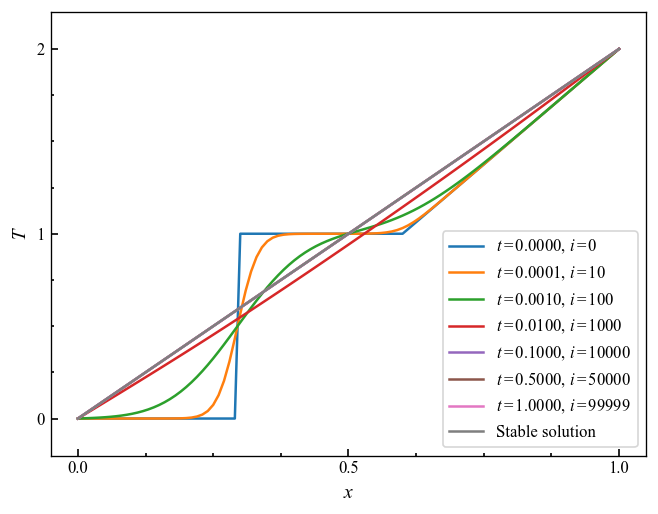

Method: BTCS, nx: 100, dx: 0.01, sigma: 1, dt: 2e-05
Solving the equation, nt: 49999
50000


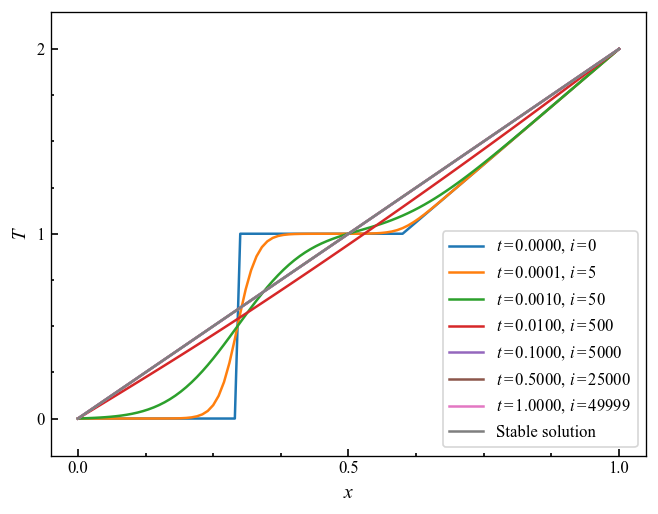

50000


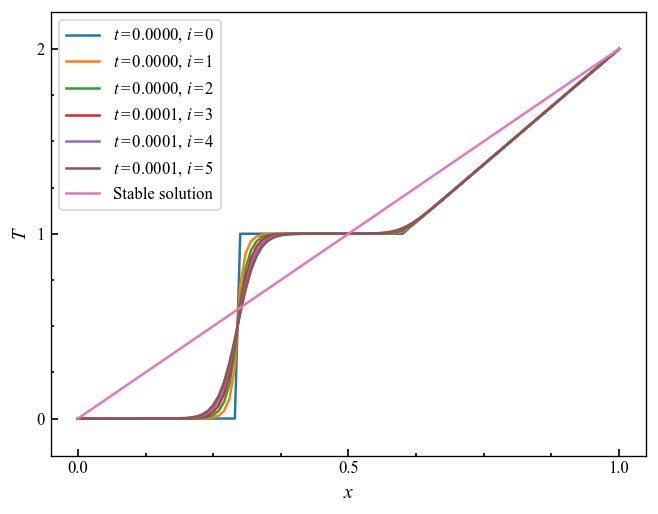

In [ ]:
testBTCS_1=BTCS(100, 0.1)
#testBTCS_1.solve(int(1/testBTCS_1.dt), set_all(int(1/testBTCS_1.dt/100)))
testBTCS_1.solve(int(1/testBTCS_1.dt))
testBTCS_1.plot_result1([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testBTCS_2=BTCS(100, 0.5)
#testBTCS_2.solve(int(1/testBTCS_2.dt), set_all(int(1/testBTCS_2.dt/100)))
testBTCS_2.solve(int(1/testBTCS_2.dt))
testBTCS_2.plot_result1([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])

testBTCS_3=BTCS(100, 1)
#testBTCS_3.solve(int(1/testBTCS_3.dt), set_all(int(1/testBTCS_3.dt/100)))
testBTCS_3.solve(int(1/testBTCS_3.dt))
testBTCS_3.plot_result1([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testBTCS_3.plot_result1([0, 1, 2, 3, 4, 5])

Method: BTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 1e-05
Solving the equation, nt: 99999
100000


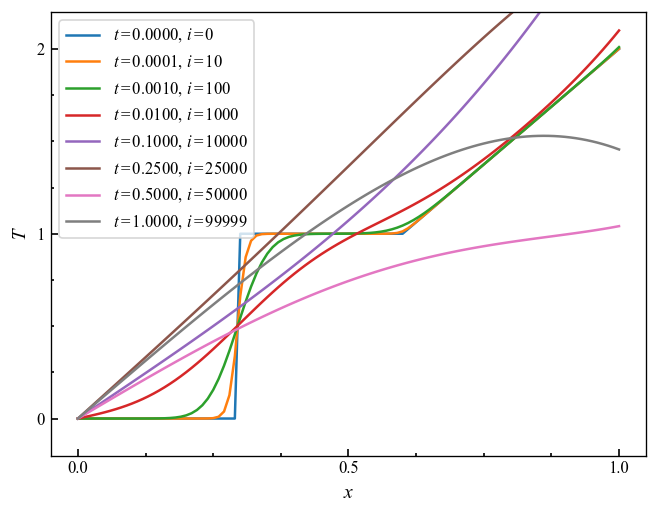

Method: BTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 5e-05
Solving the equation, nt: 20000
20001


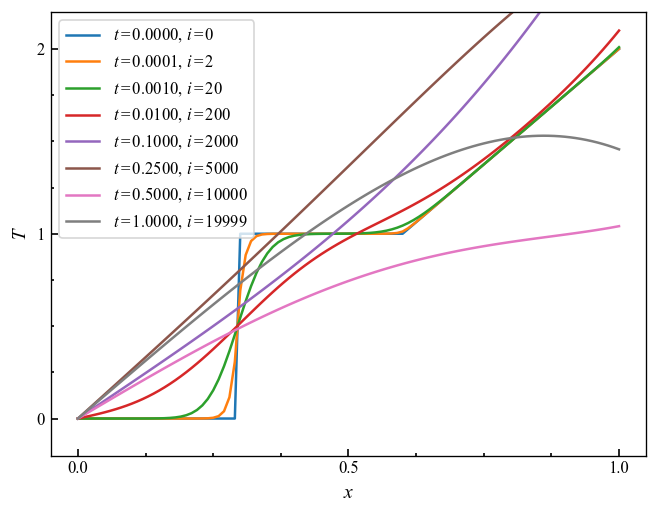

Method: BTCS, nx: 100, dx: 0.01, sigma: 1, dt: 0.0001
Solving the equation, nt: 10000
10001


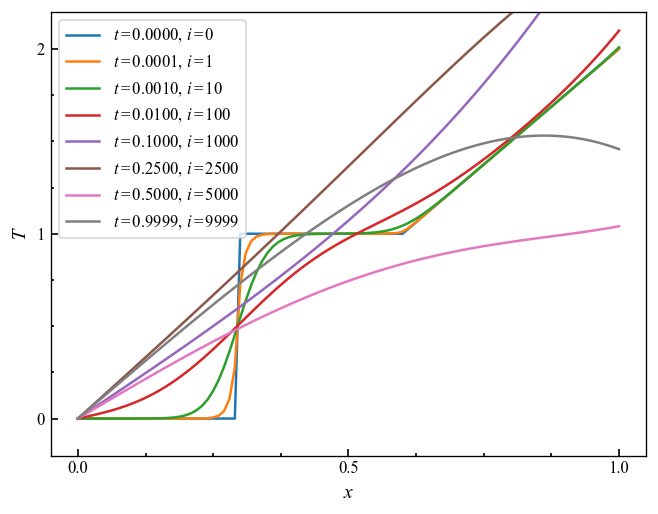

10001


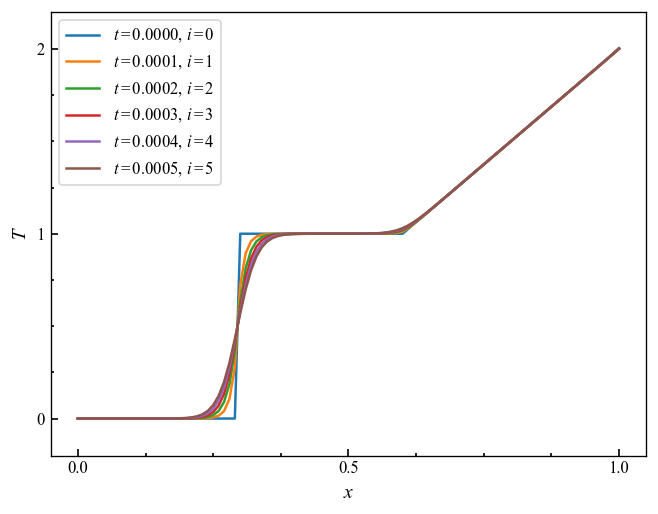

In [12]:
from math import sin
bcsin={'a': (lambda t: 0), 'b': (lambda t: 2+sin(10*t))}
testBTCS_4=BTCS(100,0.1,bcs=bcsin)
#testBTCS_4.solve(int(1/testBTCS_4.dt), set_all(int(1/testBTCS_4.dt/100)))
testBTCS_4.solve(int(1/testBTCS_4.dt))
testBTCS_4.plot_result2([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testBTCS_5=BTCS(100,0.5,bcs=bcsin)
#testBTCS_5.solve(int(1/testBTCS_5.dt), set_all(int(1/testBTCS_5.dt/100)))
testBTCS_5.solve(int(1/testBTCS_5.dt))
testBTCS_5.plot_result2([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])

testBTCS_6=BTCS(100,1,bcs=bcsin)
#testBTCS_6.solve(int(1/testBTCS_6.dt), set_all(int(1/testBTCS_6.dt/100)))
testBTCS_6.solve(int(1/testBTCS_6.dt))
testBTCS_6.plot_result2([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testBTCS_6.plot_result2([0, 1, 2, 3, 4, 5])

Method: CTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 1e-05
Solving the equation, nt: 99999


C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2358140847.py:13: RuntimeWarning: overflow encountered in multiply
  u_temp=u_curr+self.sigma*(np.roll(u_next,shift=1)-2*u_next+np.roll(u_next,shift=-1))
C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2358140847.py:13: RuntimeWarning: overflow encountered in add
  u_temp=u_curr+self.sigma*(np.roll(u_next,shift=1)-2*u_next+np.roll(u_next,shift=-1))


100000


c:\Users\Cx_330\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2919: RuntimeWarning: overflow encountered in scalar subtract
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


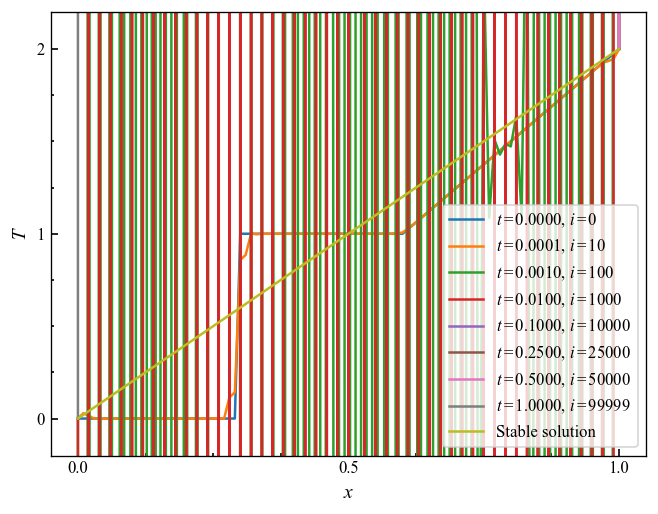

Method: CTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 5e-05
Solving the equation, nt: 20000
20001


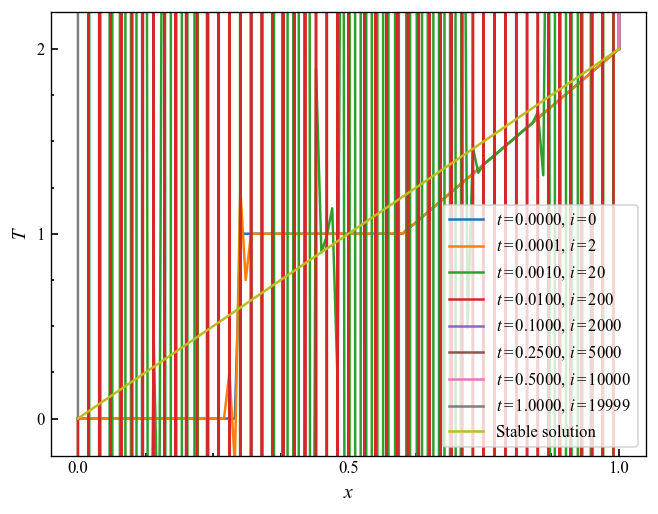

Method: CTCS, nx: 100, dx: 0.01, sigma: 1, dt: 0.0001
Solving the equation, nt: 10000
10001


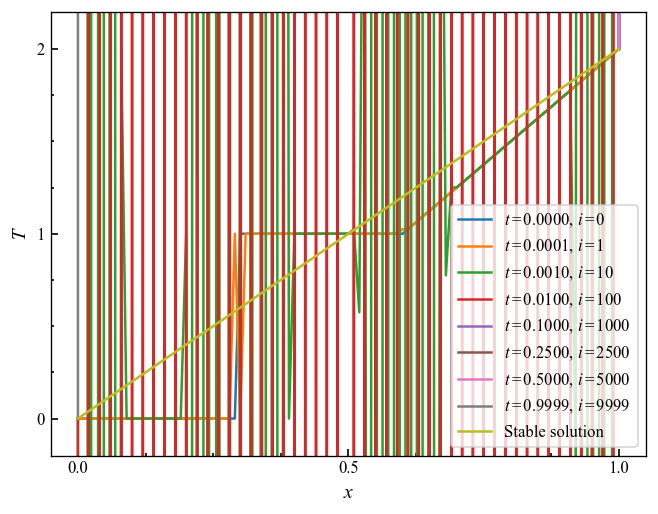

10001


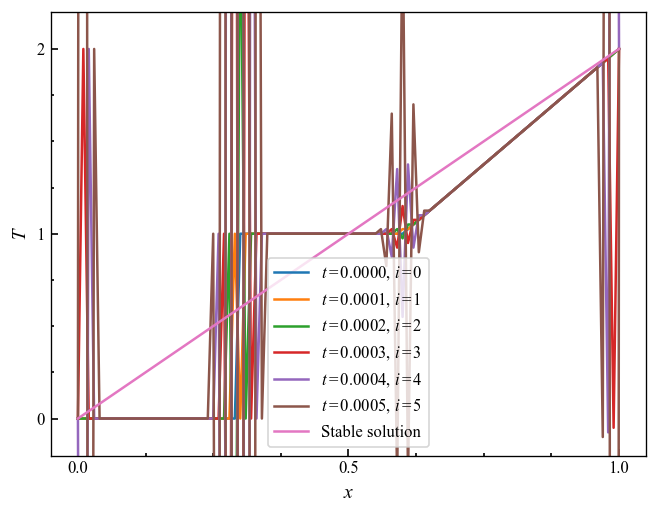

In [13]:
testCTCS_1=CTCS(100, 0.1)
#testCTCS_1.solve(int(1/testCTCS_1.dt), set_all(int(1/testCTCS_1.dt/100),ticks=[1e3,0.5e3]))
testCTCS_1.solve(int(1/testCTCS_1.dt))
testCTCS_1.plot_result1([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testCTCS_2=CTCS(100, 0.5)
#testCTCS_2.solve(int(1/testCTCS_2.dt), set_all(int(1/testCTCS_2.dt/100),ticks=[1e3,0.5e3]))
testCTCS_2.solve(int(1/testCTCS_2.dt))
testCTCS_2.plot_result1([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])

testCTCS_3=CTCS(100, 1)
#testCTCS_3.solve(int(1/testCTCS_3.dt), set_all(int(1/testCTCS_3.dt/100),ticks=[1e3,0.5e3]))
testCTCS_3.solve(int(1/testCTCS_3.dt))
testCTCS_3.plot_result1([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testCTCS_3.plot_result1([0, 1, 2, 3, 4, 5])

Method: CTCS, nx: 100, dx: 0.01, sigma: 0.1, dt: 1e-05
Solving the equation, nt: 99999


C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2358140847.py:13: RuntimeWarning: overflow encountered in multiply
  u_temp=u_curr+self.sigma*(np.roll(u_next,shift=1)-2*u_next+np.roll(u_next,shift=-1))
C:\Users\Cx_330\AppData\Local\Temp\ipykernel_12068\2358140847.py:13: RuntimeWarning: overflow encountered in add
  u_temp=u_curr+self.sigma*(np.roll(u_next,shift=1)-2*u_next+np.roll(u_next,shift=-1))


100000


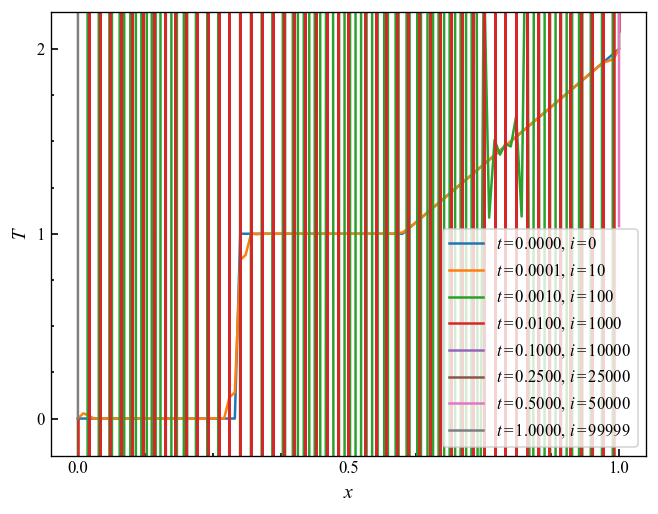

Method: CTCS, nx: 100, dx: 0.01, sigma: 0.5, dt: 5e-05
Solving the equation, nt: 20000
20001


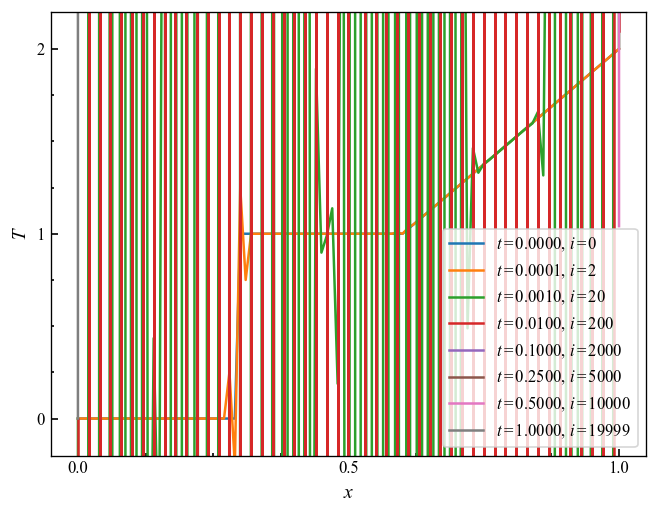

Method: CTCS, nx: 100, dx: 0.01, sigma: 1, dt: 0.0001
Solving the equation, nt: 10000
10001


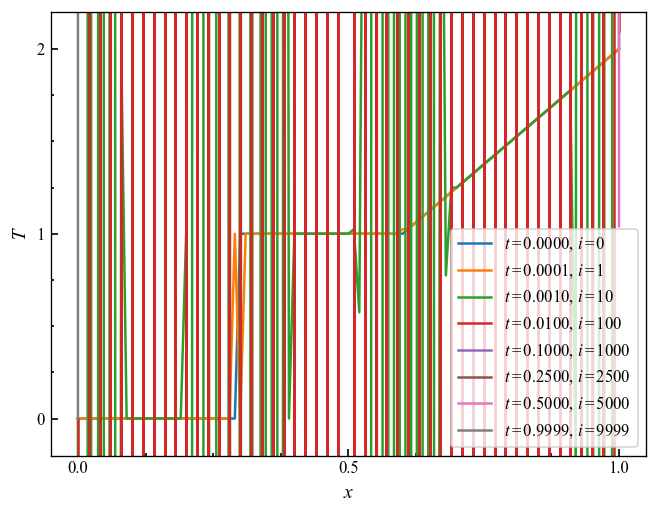

10001


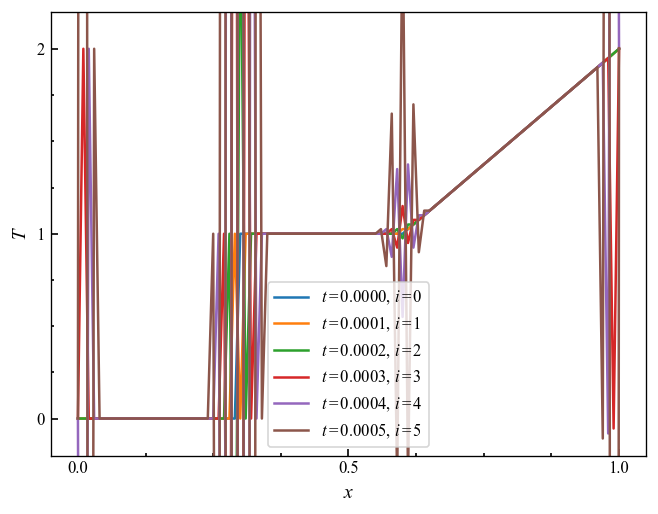

In [14]:
from math import sin
bcsin={'a': (lambda t: 0), 'b': (lambda t: 2+sin(10*t))}
testCTCS_4=CTCS(100,0.1,bcs=bcsin)
#testCTCS_4.solve(int(1/testCTCS_4.dt), set_all(int(1/testCTCS_4.dt/100),ticks=[1e3,0.5e3]))
testCTCS_4.solve(int(1/testCTCS_4.dt))
testCTCS_4.plot_result2([0, 10, 100, 1000, 10000, 25000, 50000, 100000-1])

testCTCS_5=CTCS(100,0.5,bcs=bcsin)
#testCTCS_5.solve(int(1/testCTCS_5.dt), set_all(int(1/testCTCS_5.dt/100),ticks=[1e3,0.5e3]))
testCTCS_5.solve(int(1/testCTCS_5.dt))
testCTCS_5.plot_result2([0, 2, 20, 200, 2000, 5000, 10000, 20000-1])

testCTCS_6=CTCS(100,1,bcs=bcsin)
#testCTCS_6.solve(int(1/testCTCS_6.dt), set_all(int(1/testCTCS_6.dt/100),ticks=[1e3,0.5e3]))
testCTCS_6.solve(int(1/testCTCS_6.dt))
testCTCS_6.plot_result2([0, 1, 10, 100, 1000, 2500, 5000, 10000-1])
testCTCS_6.plot_result2([0, 1, 2, 3, 4, 5])